# Histopathological image classification: Starting Kit

## Context

For this data challenge, you will work on histopathological images. The dataset consists of microscopic images of breast tumor tissue collected from several patients. These images have the following properties: 700x460 pixels, 3-channel RGB, 8-bit depth in each channel, PNG format.  

You will be provided with two subfolders. 
- **Train** contains the set of training images (with labels)
- **Test** contains the set of images on which you will be evaluated (no available labels)

### Objective and Evaluation metrics
These images correspond to samples of breast tumors that are either benign or malignant. Among malginants, we can also distinguish between different types of tumors. For this data challenge, you will be evaluated on the prediction of the type of tumors (8 possible classes). 

The chosen metric for this evalaution is the F1-Score (weighted average) implemented in scikit-learn (`sklearn.metrics.f1_score`).

# Disclaimer

 * I do not include all the process of testing new features, parameters of features and model selection. I just write some lines.
 
 * Code is not runnable because I use SIFT, i save SIFT's features because it take long time to run.

# IMPORT 

In [1]:
import numpy as np
import pandas as pd
import cv2
import mahotas
import os
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, f1_score,confusion_matrix
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import PCA

import xgboost as xgb

from scipy.spatial.distance import cdist

import skimage
from skimage import io
from skimage.feature import SIFT,ORB, hog, local_binary_pattern
from skimage.color import rgb2gray, rgb2hsv

In [2]:
# get images list from folder using os.listdir
images = os.listdir(path='data-challenge/Train/')

### Dataset building

Using the same method to load images 


* Now we can build a pandas `DataFrame` to store the information about the images. All the informations are contained in the filename of each image. 

* For example, SOB_B_TA-14-4659-40-001.png is the image 1, at magnification factor 40X, of a benign tumor of type tubular adenoma, original from the slide 14-4659, which was collected by procedure SOB. 

* Using the function `str.split` we can create new columns in the dataframe corresponding to the class, subclass and slide from each image.

**Encoding MUST be done with the following correspondance**

F->1
DC->2 
PC->3
PT->4
MC->5
LC->6
A->7
TA->8

In [3]:
def parse_fn(filename):
    # <BIOPSY_PROCEDURE>_<TUMOR_CLASS>_<TUMOR_TYPE>-<YEAR>-<SLIDE_ID>-<MAG>-<SEQ>
    parsed = filename[:-4].replace('-', '_').split('_')
    parsed.append(filename)
    return parsed

columns = ['procedure', 'class', 'type', 'magnification', 'slide', 'mag', 'seq', 'filename']

df = pd.DataFrame(list(map(parse_fn, images)), columns=columns)
label_types = df['type'].unique()

In [4]:
label_maps = {'F':'1', 'DC':'2', 'PC':'3', 'PT':'4', 'MC':'5', 'LC':'6', 'A':'7', 'TA':'8'}
df['type_id'] = df['type'].apply(lambda x: label_maps[x])


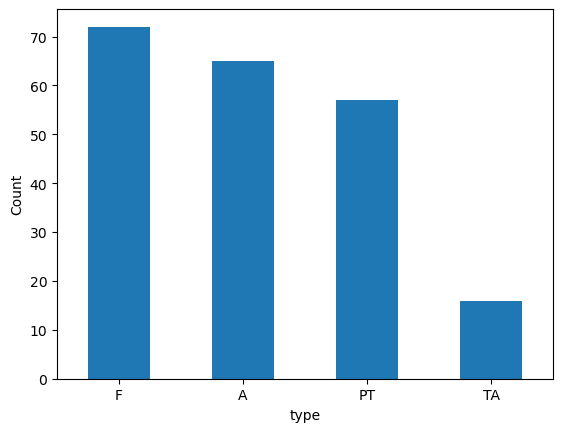

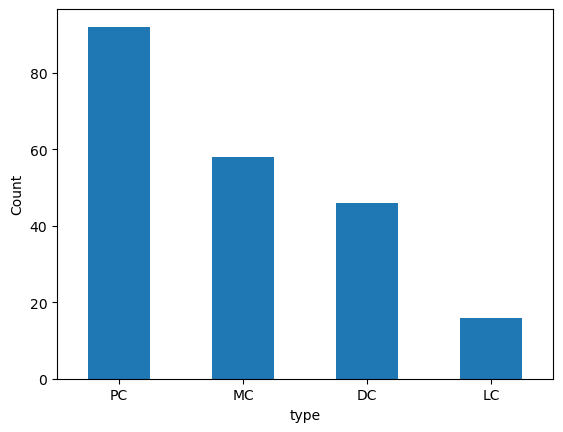

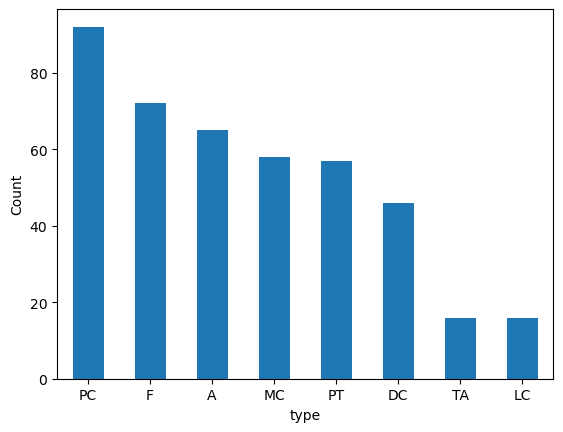

In [28]:
# Histogram of benine tumor
df_B_type = df[df['class'] == 'B']
df_B_type['type'].value_counts().plot(kind='bar', xlabel='type', ylabel='Count', rot=0)
plt.show()
# histogram of malign tumor
df_M_type = df[df['class']== 'M']
df_M_type['type'].value_counts().plot(kind='bar', xlabel = 'type', ylabel='Count', rot=0)
plt.show()
# Histogram 8 classes
df['type'].value_counts().plot(kind='bar', xlabel = 'type', ylabel='Count', rot=0)
plt.show()

# Imbalance

There is a large imbalance in the distribution of classes in a training dataset, this can pose a problem for machine learning models. The model may be biased towards the majority class and have difficulty predicting the minority class accurately.

Our case is quite complicated to deal. The first solution would be to move towards class balance by taking fewer images from the dominant classes.
The problem with this solution is that we have few images, we lose generalisation. The solution has not been implemented.

Second solution is Data augmentation. It's done by applying various transformations to the original data, such as rotating, flipping, or scaling the images. The solution doesn't improve our result. This is because generating new samples from the existing ones will not address the underlying issue of class imbalance. Instead, it may lead to an over-representation of the minority class in the augmented dataset, which can further exacerbate the bias towards the majority class.

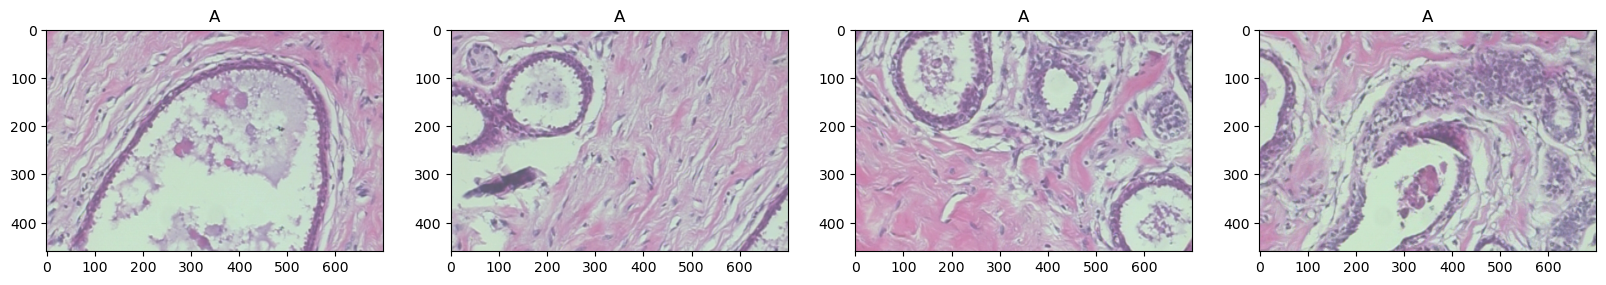

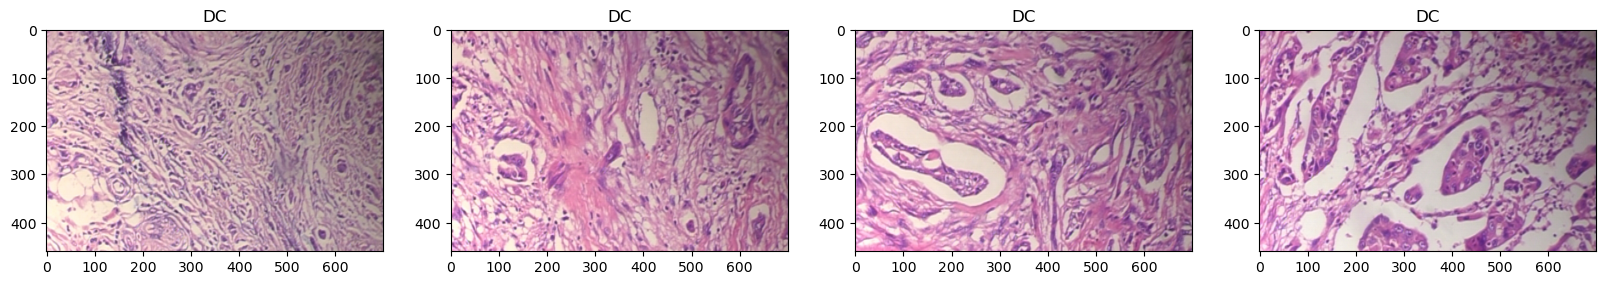

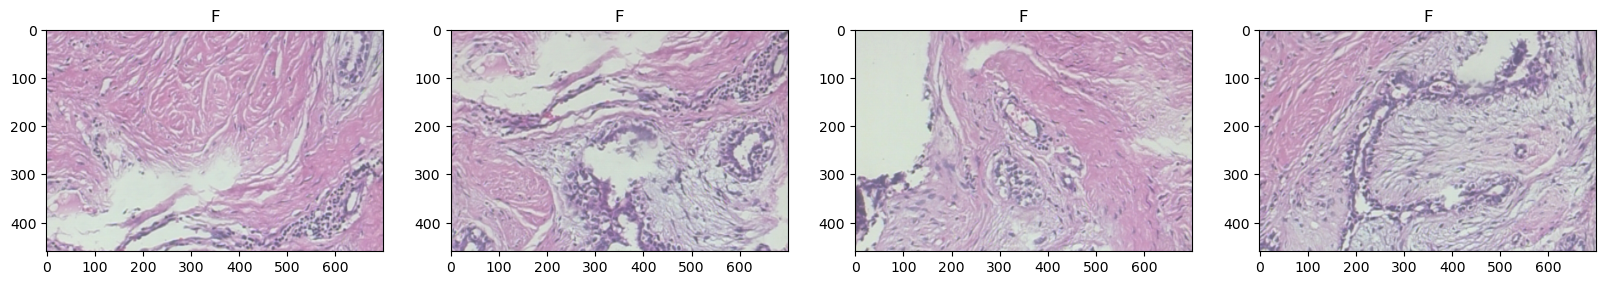

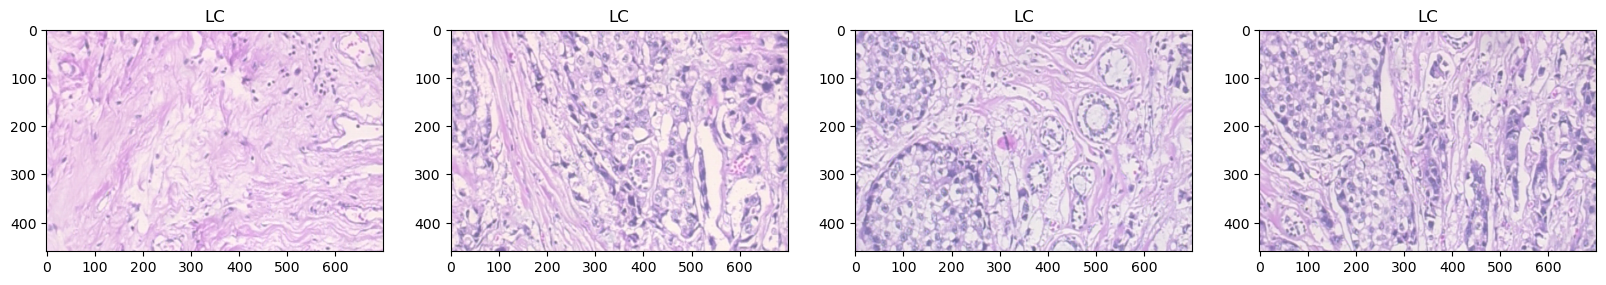

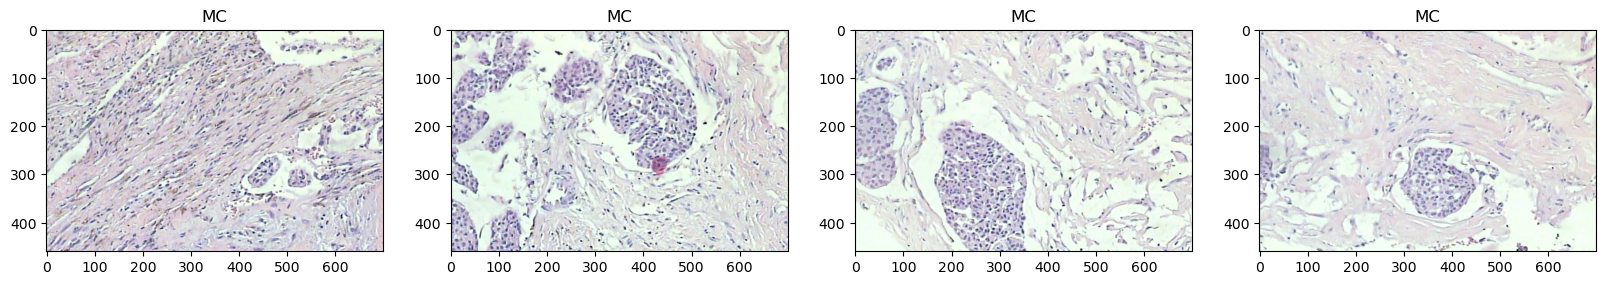

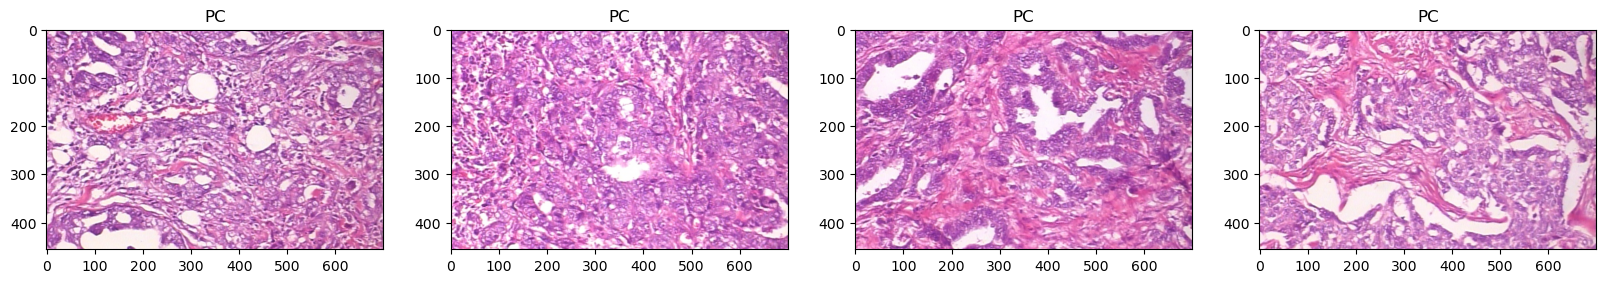

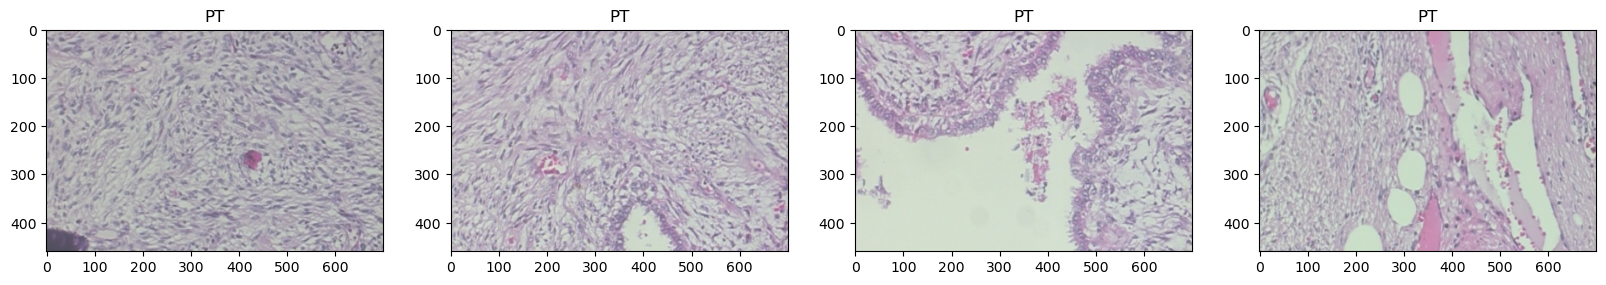

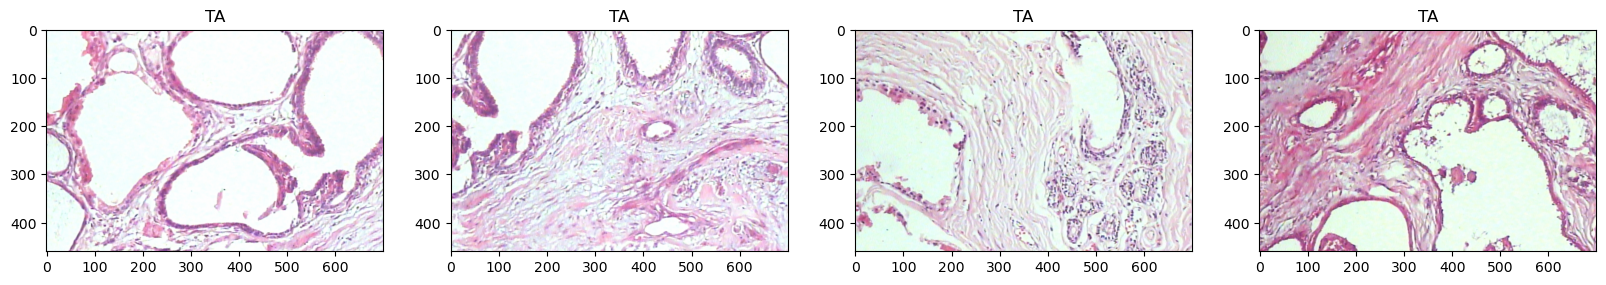

In [34]:
# group by type of tumor 8 classes
disease_groups = df.groupby("type")

for name, disease_group in disease_groups:
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 6))
    for i, ax in enumerate(axes.flatten()):
        # plot only 4 images per type
        if i >= len(disease_group) or i >= 4:
            break
        # take image
        img_path = os.path.join('data-challenge/Train/', disease_group.iloc[i].filename)
        img = cv2.imread(img_path)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(disease_group.iloc[i].type)
    plt.show()


# Biological knowledge

In order to develop effective machine learning models for tasks such as cancer detection and diagnosis, it is crucial to have a deep understanding of the underlying biology and morphology of the tissues being analyzed.

Extracting meaningful features from histopathological images requires knowledge of the different cellular structures, as well as the various patterns and textures that may indicate the presence of disease. For example, certain types of cancer cells may have distinct morphological characteristics that can be used to identify them in an image. Moreover, histopathological images often exhibit a high degree of variability, which can make it challenging to develop a robust feature extraction pipeline. In order to address this challenge, researchers often rely on domain-specific knowledge to identify relevant features and develop effective preprocessing techniques.

To answer this problem i found these article : "Machine Learning Methods for Histopathological Image Analysis: A Review" by Jonathan de Matos, Steve Tsham Mpinda Ataky, Alceu de Souza Britto Jr.,
Luiz Eduardo Soares de Oliveira and Alessandro Lameiras Koerich. There is some part really scpecific for the understanding of histopathological image

# Features extraction (from image processing)

* To perform machine learning, you need to map each image to a vector or representation. 

* Feature extraction is necessary to extract information from the raw data, in order to enrich their description. Selecting the most meaningful features is a crucial step in the process of classification problems.

* The selected set of features should be a small set whose values efficiently discriminate among patterns of the different classes, but are similar for patterns within the same class.

* Here we will use   `OpenCV`, `mahotas` and `skimage` libraries: 


# SIFT

Local features that are invariant to scale, rotation, and translation are known as SIFT features. This implies that a picture may detect the same feature regardless of its dimensions, orientation, or location. By locating different keypoints in a picture and obtaining a description for each keypoint, the SIFT method operates. The keypoint is a region of the image that, due to its brightness or gradient strength, stands out.

There are four main steps in the SIFT algorithm:

* Scale-space extrema detection: To begin, the algorithm transforms the image into a scale-space representation by convolving it with Gaussian kernels of progressively larger sizes. The local extrema (maxima and minima) in the scale space that correspond to prospective keypoints are then identified.

* Keypoint localization: The method eliminates keypoints that have low contrast, are too edge-like, or are situated in an unstable area.

* The method determines the orientation for each keypoint based on the gradient axes of the adjacent pixels. The feature is now rotation-invariant as a result.

* The process ends with the production of a feature description for each keypoint by constructing a histogram of the gradient orientations in the immediate vicinity. A vector of numbers that reflects the local picture structure surrounding the keypoint serves as the description that is produced.

It's advantageous because to their robustness to scaling, rotation, and translation.

The disadvantage is that the data augmentation becomes much less interesting. As we will see later, other features are invariant to scaling, rotation, and translation.

# SIFT + BOW

I use an implementation of the Bag of Visual Words (BoW) paradigm for picture categorization is used in the described approach.

The initial function, "extract sift features," takes a list of picture paths and uses the SIFT method to extract SIFT features for each image. The local visual structure surrounding important spots is described by the SIFT features, which are descriptors. The final descriptors are listed and kept in storage.

In the function "kmean bow," all the descriptors from the previous phase are used to perform k-means clustering in order to produce a dictionary of visual words. The "num cluster" option specifies how many clusters there are. The "bow dict" variable contains the cluster centers that are produced.

A dictionary must be created from the training images AND the test images. Then the SIFT image descriptors have to be created again for the training images and in a second step for the test images.

In [7]:
def extract_sift_features(list_image):
    cnt = 0
    list_descriptors = []
    descriptor_extractor = SIFT()

    for img_path in list_image:
        img = skimage.io.imread("data-challenge/Test/"+ img_path)
        # gray level
        img = rgb2gray(img)
        descriptor_extractor.detect_and_extract(img) # instantiate extractor
        des = descriptor_extractor.descriptors# extract sift features
        list_descriptors.append(des)
        
    return list_descriptors 

def kmean_bow(all_descriptors, num_cluster):
    # Create a BoW
    bow_dict = []

    kmeans = KMeans(n_clusters = num_cluster)
    kmeans.fit(all_descriptors)

    bow_dict = kmeans.cluster_centers_

    return bow_dict

In [8]:
# image_descriptors = extract_sift_features(images_test)
# all_descriptors = np.vstack([des for des_list in image_descriptors for des in des_list])

# # save the array to a file
# np.save('SIFT/image_descriptors_test_last.npy', image_descriptors)
# np.save('SIFT/all_descriptors_test_last.npy', all_descriptors)
# all_descriptors.shape

# num_cluster = 200
# Run k-means clustering
# bow_dict = kmean_bow(all_descriptors, num_cluster)
# print(bow_dict.shape)

# save an array
# np.save('SIFT/bow_dict_200_train_test_last.npy', bow_dict)
# bow_dict.shape

In [9]:
bins = 10 # nbr de  bin d'histogram

# functions to extract features from the images
def fd_haralick(image):
    # optimisation of the parameter from haralick
    haralick = mahotas.features.haralick(image,compute_14th_feature=True, use_x_minus_y_variance=True, distance = 2).ravel()
    return haralick

def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # HSV allow a better classification
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten() # flatten to have a vector of feature

def fd_lbp(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # local binary pattern
    lbp = local_binary_pattern(gray, P=8, R=1)
    # create a histogram
    hist, bins = np.histogram(lbp.flatten(), bins=np.arange(0, 255), range=(0, 256))
    # normalize
    hist = hist / np.sum(hist)
    return hist.flatten()

def fd_tcas(image):
    # pftas from mahotas
    feature = mahotas.features.pftas(image)
    return feature

* I have kept the basic notebook approach. I create one function per feature. Each function takes an image as input and performs the operations. 
* In the boxes below we see the size of the features for a single image.

In [10]:
img = cv2.imread('data-challenge/Train/' + images[0])
fd_haralick(img).shape

(182,)

In [11]:
fd_histogram(img).shape

(1000,)

In [12]:
fd_lbp(img).shape

(254,)

In [13]:
fd_tcas(img).shape

(162,)

# Create feature SIFT

In the code below, we load the SIFT image descriptors of the training images. We use our BOW to create a feature vector of size 200.

This code defines a function called create_feature_bow that takes three arguments: image_descriptors, which is a list of SIFT descriptors for a set of images. BoW, which is a numpy array representing the Bag-of-Words (BoW) dictionary created using k-means clustering of the SIFT descriptors; and num_cluster, which is the number of clusters used to create the BoW dictionary. The function computes the Euclidean distance between each of its SIFT descriptors and the centroids of the clusters in the BoW dictionary using the cdist function from the scipy.spatial.distance module. It then finds the index of the closest cluster for each descriptor using np.argmin. For each image, the function increments the corresponding entry in the X_features array for the cluster associated with each of its SIFT descriptors. In this way, the function computes the histogram of cluster assignments for each image, which can be used as a feature vector for machine learning tasks.

In [14]:
# Load an array because time consuming to run SIFT each time
all_descriptors = np.load('SIFT/all_descriptors.npy')
print("All descriptor of images (shape) : ",all_descriptors.shape)
image_descriptors = np.load('SIFT/image_descriptors.npy', allow_pickle=True)
print("Descriptor of the image (shape) : ",image_descriptors.shape)
# Load our BoW take so much time to create
bow_dict = np.load('SIFT/bow_dict_200_train_test.npy')
print("bow dict (shape : ",bow_dict.shape)


def create_feature_bow(image_descriptors, BoW, num_cluster):
    # Use descrptors of image Train or Test
    X_features = np.zeros((len(image_descriptors), num_cluster))
    for i in range(len(image_descriptors)):
        # for each one we are going to look at the distance to our Bow
        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], BoW)
            argmin = np.argmin(distance, axis = 1)
            for j in argmin:
                X_features[i, j] += 1
    return X_features

num_cluster = 200 # number of features
features_sift = create_feature_bow(image_descriptors, bow_dict, num_cluster)
print(f"SIFT TRAIN (shape) : ",features_sift.shape)

All descriptor of images (shape) :  (1831909, 128)
Descriptor of the image (shape) :  (422,)
bow dict (shape :  (200, 128)
SIFT TRAIN (shape) :  (422, 200)


In [15]:
# Compute the features
feat_haralick = []
feat_histogram = []
feat_lbp = []
feat_tcas = []
             
for i in images:
    img = cv2.imread('data-challenge/Train/' + i)  # Load image
    feat_haralick.append(fd_haralick(img))  # Append Haralick values
    feat_histogram.append(fd_histogram(img))  # Append Histogram values
    feat_lbp.append(fd_lbp(img))
    feat_tcas.append(fd_tcas(img))

In [16]:
# Concatenate all our features
df_features = np.hstack([features_sift,feat_lbp,feat_histogram, feat_haralick,feat_tcas])
X = pd.DataFrame(df_features) # transform in DataFrame
y=df['type_id'].copy()
print(" Shape of training feature : ", X.shape)
print(" Shape of training labels : ", y.shape)

 Shape of training feature :  (422, 1798)
 Shape of training labels :  (422,)


# Features 

I implemented a lot of features during this challenge. It is important to understand that there are two types of features, local and global.

Local features are image attributes that characterize specific areas within a picture. Typically, they are extract using algorithms like SIFT. Keypoints, or regions of an image that stand out due to their intensity or gradient magnitude, serve as the foundation for local characteristics. For tasks like picture matching and object recognition, local features are advantageous since they are frequently resistant to changes in scale, rotation, and lighting.

On the other hand, global characteristics are those in an image that describe the entire image as a whole. There is color histograms, GIST features, they are used to extract them. Global features, which often take the form of a vector of numerical values, are used to describe the color, texture, and spatial arrangement of a picture. It's use for applications like image retrieval and scene recognition.

Features that I implemented but did not give good results, HOG, Zernike, HU, HSV histogram, Haematoxylin-Eosin-DAB (HED) histogram. I also tested the features parameters to see the changes (number of bins, etc).

With SIFT I use :

* Haralick features: It's a texture features, haralick features are statistical measurements that characterize the texture of an image. Haralick features, which are frequently used for tasks like texture segmentation and categorization, include measurements like contrast, homogeneity, energy, and entropy.

* A histogram is a graphic depiction of how the pixel values in an image are distributed. The vertical axis shows the amount of pixels in the image that have a given intensity value, while the horizontal axis shows the pixel intensity values.

* Local Binary Pattern (LBP): LBP is a texture categorization and analysis feature descriptor. A histogram that depicts the texture of the picture is then made using the generated binary codes. LBP is frequently used in applications like face and object identification because it is resistant to changes in illumination.

* The Texture and Color Association System (TCAS) combines texture and color characteristics. In order for it to function, the image must first be divided into tiny patches from which texture and color information can be extracted. Then a weighted is used to combine these characteristics.

With the 5 features I tested several combinations with several classifiers to see the score. I saw that by cumulating the 5 features I got the best score. I use cross val score and train_test_split to evaluate my result. When I found a correct result I submit my prediction to confirm my feature selection. I perform also an ablation study of all my feature together to have a second confirmation.

# Normalize/Scale

One of the problems I couldn't solve and i still don't understand was the order (1e3 to 1e-3) of my features. There was a clear difference between some of my features. Some features I normalise (histogram) while others I do not. I tried normalizing each one, or using sklearn's StandardScaler to get an equal range. But the results are inferior to my current solution.

# PCA
Then I tried to reduce the size of my features with a PCA. On the current 1798 features I did not get any improvement. I then increased my HSV histogram to 50 bins. I got a total of 125000 features only for my histogram. But as before the PCA did not help me. To know the number of components I needed I looped through testing between 50 and 150. For each component value I applied my PCA, classified my validation data with three classifiers individually (Random forest, XGB and SVC) and a cross_val_score. I displayed the curve of the classification scores according to the number of components.


# Training a Classifier

### Model
First i perform train_test_split, a function in Python's scikit-learn library that is used to split a dataset into two separate subsets: a training set and a testing set (our case a validation set).

I tested my features on individual models: Non-linear SVC, Naive Bayes Gaussian, Decision Tree, kNN, Gradient Boosting Classifier, Random Forest Classifier, Extreme Gradient Boosting Classifier, Linear SVC (L1), Linear SVC (L2), Logistic Regression (L1), Logistic Regression (L2)
For each I displayed the accuracy, the f1 score and the confusion matrix. This allowed me to understand which features were important, whether a classifier was able to classify one class better than another, etc. 

The first thing I noticed was that some of them stood out, especially the ensemble models. But depending on the features the classifiers were different. So I decided to combine them with VotingClassifier() from sklearn.
It works by aggregating the predictions of each individual model and making a final prediction based on the aggregated results.
VotingClassifier supports two types of voting: hard voting and soft voting. Hard voting involves taking the majority vote of the individual models, while soft voting involves taking the average probability of each class across all of the individual models and then making a prediction based on the highest average probability.

Of course I also used cross_val_score to see if my model could generalise. The results are not very good I don't know if it's because of the difference between the classes. I set cv=16 so that in each split there are all classes represented.

I also fixed the random states to remove any randomness in the final tests.

After looking at each classifier individually I took the best ones. Even though RandomForestClassifier, GradientBoostingClassifier and XGBClassifier are quite similar, these are the best results I got. I try to avoid variability with multiple cross_val_score and sometime fixing random_state. What is interesting to note is that each classifies classes better than the other so combining them gives a performance improvement. While both XGB and GB use gradient boosting techniques to improve the performance of decision trees, they have different implementations and can have different strengths and weaknesses.

# Grid Search

For the parameters I used Grid Search to find hyperparameters. But because I had 4 models, there were too many parameters to test. So I tested just parameters like n_estimators and max_depth. It is interesting to note that the number of estimators is small for each. If you increase the value too much the model becomes over predicted (high probability) so it hurts the VotingClassifier. It needs some uncertainty to generalise and perform.

0.9302325581395349
              precision    recall  f1-score   support

           1       1.00      0.71      0.83         7
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         9
           4       0.75      1.00      0.86         6
           5       0.86      1.00      0.92         6
           6       1.00      0.50      0.67         2
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00         2

    accuracy                           0.93        43
   macro avg       0.95      0.90      0.91        43
weighted avg       0.95      0.93      0.93        43

0.9100274725274725


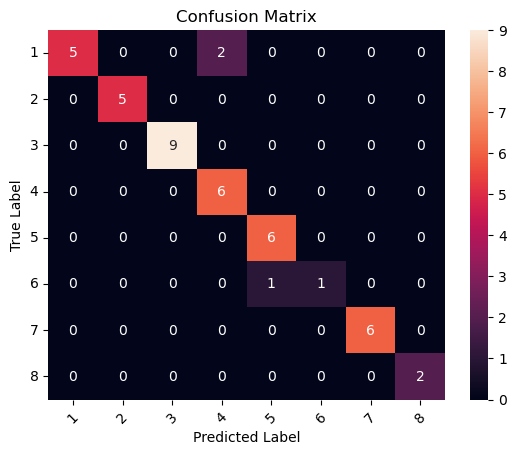

In [17]:
# Create our different classifiers
RF = RandomForestClassifier(n_estimators = 100, max_depth = 100, class_weight = 'balanced',n_jobs=-1, random_state = 30)
svm = SVC(kernel='linear',probability=True,class_weight = 'balanced', C = 0.01, random_state = 1)
GB = GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.05, max_depth = 3, random_state = 30)
xgb_cl = xgb.XGBClassifier(learning_rate = 0.01, n_estimators= 100, max_depth = 10, n_jobs=-1, random_state = 30)

# Create the ensemble of classifiers
ensemble = VotingClassifier(estimators=[('RF',RF), ('xgb_cl', xgb_cl),('GB',GB),('svm',svm)], voting='soft', n_jobs = -1) # , weights=[1,1,1]

# Split our data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y)

# Train our model
ensemble.fit(X_train, y_train)

# Predict our validation data
y_pred_val = ensemble.predict(X_val)

# Print our scores
print(accuracy_score(y_val,y_pred_val))
print(classification_report(y_val, y_pred_val))
print(f1_score(y_val, y_pred_val, average='macro'))

# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred_val)
ax = sns.heatmap(cm, annot=True, fmt='d')
unique_array = list(set(y_val))
unique_array.sort()
ax.set_xticklabels(unique_array, rotation=45)
ax.set_yticklabels(unique_array, rotation=0)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [18]:
RF = RandomForestClassifier(n_estimators = 100, max_depth = 100, class_weight = 'balanced',n_jobs=-1, random_state = 30)
svm = SVC(kernel='linear',probability=True,class_weight = 'balanced', C = 0.01, random_state = 1)
GB = GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.05, max_depth = 3, random_state = 30)
xgb_cl = xgb.XGBClassifier(learning_rate = 0.01, n_estimators= 100, max_depth = 10, n_jobs=-1, random_state = 30)

# Create the ensemble of classifiers
ensemble = VotingClassifier(estimators=[('RF',RF), ('xgb_cl', xgb_cl),('GB',GB),('svm',svm)], voting='soft', n_jobs = -1) # , weights=[1,1,1]

scores = cross_val_score(ensemble, X, y, cv=16, scoring='f1_weighted', n_jobs=-1) # 16 car essaye de répartir un label par cv et on a un mini de 16
print(" Scores of cross_val_scores ", scores)
print(" Mean score of %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

 Scores of cross_val_scores  [0.65630666 0.68877018 0.78349387 0.77671958 0.7930629  0.75745037
 0.68430458 0.66953047 0.77018174 0.86652237 1.         0.88827839
 0.92026862 0.83241758 0.63461538 0.73076923]
 Mean score of 0.78 with a standard deviation of 0.10


### Result

There is an important standard deviation (I fixed random state) for our cross val => class imbalance. 
Because of our class imbalance it is difficult to counteract the randomness of our predictions on our validation set. Furthermore the results are very different from our test data when we submit our csv to the site. With one test I could tell that class 6 was a problem. So there are two possibilities, it may be over represented in the test set or labels are exchanged but it seems odd to me.

As I said there is a big difference between our train test split and cross val score results and especially with the test data.


# Time to predict our test set

In [19]:
# Test images
images_test = os.listdir(path='data-challenge/Test/')

def parseTest_fn(filename):
    # <BIOPSY_PROCEDURE>_<ID>
    parsed = filename[:-4].split('_')
    parsed.append(filename)
    return parsed

columns = ['procedure', 'id', 'filename']

df_test = pd.DataFrame(list(map(parseTest_fn, images_test)), columns=columns)
print(df_test.head())
print(df_test.shape)

  procedure   id     filename
0       SOB    1    SOB_1.png
1       SOB   10   SOB_10.png
2       SOB  100  SOB_100.png
3       SOB  101  SOB_101.png
4       SOB  102  SOB_102.png
(207, 3)


In [20]:
# load an array
image_descriptors_test = np.load('SIFT/image_descriptors_test_last.npy', allow_pickle=True)

num_cluster = 200
sift_features_test = create_feature_bow(image_descriptors_test, bow_dict, num_cluster)
print(sift_features_test.shape)

(207, 200)


In [21]:
# Compute the features
feat_haralick_test = []
feat_histogram_test = []
feat_lbp_test = []
feat_tcas_test = []

for i in images_test:
    img = cv2.imread('data-challenge/Test/' + i)  # Load image
    feat_haralick_test.append(fd_haralick(img))  # Append Haralick values
    feat_histogram_test.append(fd_histogram(img))  # Append Histogram values
    feat_lbp_test.append(fd_lbp(img))
    feat_tcas_test.append(fd_tcas(img))
    


In [22]:
# Concatenate with the original data frame 
df_features_test = np.hstack([sift_features_test,feat_lbp_test,feat_histogram_test,feat_haralick_test,feat_tcas_test])
X_test = pd.DataFrame(df_features_test)
X_test.shape

(207, 1798)

In [23]:
RF = RandomForestClassifier(n_estimators = 100, max_depth = 100, class_weight = 'balanced',n_jobs=-1, random_state = 30)
svm = SVC(kernel='linear',probability=True,class_weight = 'balanced', C = 0.01, random_state = 1)
GB = GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.05, max_depth = 3, random_state = 30)
xgb_cl = xgb.XGBClassifier(learning_rate = 0.01, n_estimators= 100, max_depth = 10, n_jobs=-1, random_state = 30)

# Create the ensemble of classifiers
ensemble = VotingClassifier(estimators=[('RF',RF), ('xgb_cl', xgb_cl),('GB',GB),('svm',svm)], voting='soft', n_jobs = -1) # , weights=[1,1,1]

ensemble.fit(X,y)

y_pred_test = ensemble.predict(X_test)

In [24]:
df_pred = pd.concat([df_test['id'], pd.Series(y_pred_test, name='type_id')], axis=1)
display(df_pred['type_id'].value_counts())
df_pred.to_csv('my_pred.csv', index=False, header=False)

7    62
2    49
3    33
1    24
4    22
5    16
8     1
Name: type_id, dtype: int64

# Possible leads or improvement

* Continue to work on the features to better adapt them to our images. Taking generic features is not enough. 

* Continue to research the parameters of our four models.

* I tried a two-step approach which I have not mentioned. First classify between benign and malignant, then in a second step find the four classes for each. I implemented it at the very beginning but I didn't have the time to redo because it required me to recalculate SIFT at each new classification.


In [1]:
!pip freeze > requirements.txt